In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore, rankdata
import matplotlib.pyplot as plt


# gamma = 0.9
device = 'cpu'

pd.set_option('display.max_columns', None)

In [3]:
data_file_path = '../data/synthetic-acute-hypotension-and-sepsis-datasets-based-on-mimic-iii-and-published-as-part-of-the-health-gym-project-1.0.0/C001_FakeHypotension.csv'

In [4]:
df = pd.read_csv(data_file_path, index_col=0)


In [5]:
df.columns

Index(['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'PO2',
       'lactic_acid', 'serum_creatinine', 'fluid_boluses', 'vasopressors',
       'FiO2', 'GCS_total', 'urine_m', 'ALT_AST_m', 'FiO2_m', 'GCS_total_m',
       'PO2_m', 'lactic_acid_m', 'serum_creatinine_m', 'PatientID',
       'Timepoints'],
      dtype='object')

In [6]:
action_vars = ['fluid_boluses', 'vasopressors']
state_vars = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'PO2', 'lactic_acid',  'serum_creatinine', 'FiO2', 'GCS_total',
              'urine_m', 'ALT_AST_m', 'FiO2_m', 'GCS_total_m', 'PO2_m', 'lactic_acid_m', 'serum_creatinine_m']

In [7]:
# Discrete action space
# Fluid Boluses, categorical, mL
# Vasopressors, categorical, mcg/kg/min

action_counts = df.groupby(action_vars).size().unstack(fill_value=0)
print("Tabular Count of Actions:")
print(action_counts)

# Define the discrete levels for fluid boluses and vasopressors
fluid_bolus_levels = [0, 250, 500, 1000]
vasopressors_levels = [0, 0.000001, 8.4, 20.28]

# Create a mapping for each combination of (fluid_bolus, vasopressor) into a unique integer
action_mapping = {}
action_counter = 0

for fb in fluid_bolus_levels:
    for vp in vasopressors_levels:
        action_mapping[(fb, vp)] = action_counter
        action_counter += 1

# Function to encode the actions in the dataframe
def encode_actions(row):
    fb = row['fluid_boluses']
    vp = row['vasopressors']
    return action_mapping[(fb, vp)]

# Apply the encoding to the dataframe to create a single action column
df['action'] = df.apply(encode_actions, axis=1)

Tabular Count of Actions:
vasopressors   0.000000   0.000001   8.400000   20.280000
fluid_boluses                                            
0                 153892      15121       6658       6978
250                  402         20         14         86
500                 2268        274        164         32
1000                1358        234         79        100


In [8]:
patient_ids = df['PatientID'].unique()

# Number of cross-validation splits
ncv = 10  

np.random.seed(42) 
grp = np.floor(ncv * np.random.rand(len(patient_ids), 1) + 1)

# Define group numbers for training, validation, and testing
crossval1 = 1  # Group for validation
crossval2 = 2  # Group for testing

# Assign patients to training, validation, and test sets
train_patients = patient_ids[np.where(grp > crossval2)[0]]
validation_patients = patient_ids[np.where(grp == crossval1)[0]]
test_patients = patient_ids[np.where(grp == crossval2)[0]]

# Create boolean masks for the dataset based on the patient splits
train_mask = np.isin(df['PatientID'], train_patients)
validation_mask = np.isin(df['PatientID'], validation_patients)
test_mask = np.isin(df['PatientID'], test_patients)

# Split the dataset
train_df = df[train_mask]
validation_df = df[validation_mask]
test_df = df[test_mask]

train_df.shape[0] + validation_df.shape[0] + test_df.shape[0] == df.shape[0]

True

In [9]:
# Columns to scale and not scale
colnorm = ['MAP', 'diastolic_bp', 'systolic_bp', 'PO2', 'lactic_acid', 'FiO2', 'GCS_total']
collog = ['urine', 'ALT', 'AST', 'serum_creatinine']
colnotscale = [c for c in df.columns if c not in colnorm + collog]

# Initialize scalers
scaler_norm = StandardScaler()
scaler_log = StandardScaler()

def scale_data(df, train=True):
    # Split into categories
    df_norm = df[colnorm]
    df_log = df[collog]
    df_cat = df[colnotscale] 

    # Fit scalers only on the training data
    if train:
        scaled_norm = scaler_norm.fit_transform(df_norm)
        scaled_log = scaler_log.fit_transform(np.log(0.1 + df_log))  # Log transformation before scaling
    else:
        scaled_norm = scaler_norm.transform(df_norm)
        scaled_log = scaler_log.transform(np.log(0.1 + df_log))
    
    # Convert scaled arrays back into DataFrames
    scaled_norm_df = pd.DataFrame(scaled_norm, columns=colnorm, index=df.index)
    scaled_log_df = pd.DataFrame(scaled_log, columns=collog, index=df.index)
    
    # Concatenate the scaled numeric/log DataFrames with unscaled columns
    scaled_df = pd.concat([scaled_norm_df, scaled_log_df, df_cat], axis=1)

    return scaled_df

# Apply scaling to train, validation, and test data
scaled_train_df = scale_data(train_df, train=True)
scaled_validation_df = scale_data(validation_df, train=False)
scaled_test_df = scale_data(test_df, train=False)

In [10]:
def compute_reward(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward


# Process patient data using the scaled data, but unscaled 'MAP' for reward
def process_patient_data(data, original_data):
    data = data.sort_values(by=['PatientID', 'Timepoints']) # Sort by PatientID and Timepoints to ensure correct order
    original_data = original_data.sort_values(by=['PatientID', 'Timepoints'])

    # Prepare lists to store transitions
    states = []
    next_states = []
    actions = []
    next_actions = []
    rewards = []
    dones = []
    bloc_num = []

    # Iterate over each patient
    unique_patients = data['PatientID'].unique()

    for patient in unique_patients:
        patient_data = data[data['PatientID'] == patient]
        original_patient_data = original_data[original_data['PatientID'] == patient]

        for i in range(len(patient_data) - 1):
            current_state = patient_data.iloc[i]
            next_state = patient_data.iloc[i + 1]

            original_current_state = original_patient_data.iloc[i]
            original_next_state = original_patient_data.iloc[i + 1]

            states.append(current_state[state_vars].values)
            next_states.append(next_state[state_vars].values)

            actions.append(current_state[['action']].values)
            next_actions.append(next_state[['action']].values)

            # Compute the reward using unscaled 'MAP' (from original data)
            rewards.append(compute_reward(original_current_state, original_next_state))

            # Last time point for the patient
            done = 1 if i == len(patient_data) - 2 else 0
            dones.append(done)

            bloc_num.append(patient)

    return np.array(states), np.array(next_states), np.array(actions), np.array(next_actions), np.array(rewards), np.array(dones), np.array(bloc_num)

In [10]:
# Process the patient data for training and testing, using the original unscaled dataframe for reward calculation
train_states, train_next_states, train_actions, train_next_actions, train_rewards, train_dones, train_bloc_num = process_patient_data(scaled_train_df, train_df)
validation_states, validation_next_states, validation_actions, validation_next_actions, validation_rewards, validation_dones, validation_bloc_num = process_patient_data(scaled_validation_df, validation_df)
test_states, test_next_states, test_actions, test_next_actions, test_rewards, test_dones, test_bloc_num = process_patient_data(scaled_test_df, test_df)

In [11]:
train_states_tensor = torch.FloatTensor(train_states).to(device)
train_next_states_tensor = torch.FloatTensor(train_next_states).to(device)
train_actions_tensor = torch.LongTensor(train_actions).to(device)
train_next_actions_tensor = torch.LongTensor(train_next_actions).to(device)
train_rewards_tensor = torch.FloatTensor(train_rewards).to(device)
train_dones_tensor = torch.FloatTensor(train_dones).to(device)
train_SOFAS_tensor = torch.randint(0, 25, train_states.shape[:1], device=device)  # Just a dummy for now

validation_states_tensor = torch.FloatTensor(validation_states).to(device)
validation_next_states_tensor = torch.FloatTensor(validation_next_states).to(device)
validation_actions_tensor = torch.LongTensor(validation_actions).to(device)
validation_next_actions_tensor = torch.LongTensor(validation_next_actions).to(device)
validation_rewards_tensor = torch.FloatTensor(validation_rewards).to(device)
validation_dones_tensor = torch.FloatTensor(validation_dones).to(device)
validation_SOFAS_tensor = torch.randint(0, 25, validation_states.shape[:1], device=device)  # Just a dummy for now

test_states_tensor = torch.FloatTensor(test_states).to(device)
test_next_states_tensor = torch.FloatTensor(test_next_states).to(device)
test_actions_tensor = torch.LongTensor(test_actions).to(device)
test_next_actions_tensor = torch.LongTensor(test_next_actions).to(device)
test_rewards_tensor = torch.FloatTensor(test_rewards).to(device)
test_dones_tensor = torch.FloatTensor(test_dones).to(device)
test_SOFAS_tensor = torch.randint(0, 25, test_states.shape[:1], device=device)  # Just a dummy for now

In [12]:
class DistributionalDQN(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(DistributionalDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        self.fc_val = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.fc_adv = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, state):
        conv_out = self.conv(state)
        val = self.fc_val(conv_out)
        adv = self.fc_adv(conv_out)
        return val + adv - adv.mean(dim=1, keepdim=True)

# The Dist_DQN class is the manager of training and evaluation
class Dist_DQN(object):
    def __init__(self, state_dim=18, num_actions=16, device='cpu', gamma=0.999, tau=0.1):
        self.device = device
        self.Q = DistributionalDQN(state_dim, num_actions).to(device)
        self.Q_target = copy.deepcopy(self.Q)
        self.tau = tau
        self.gamma = gamma
        self.num_actions = num_actions
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=0.0001)

    def train(self, batchs, epoch):
        (state, next_state, action, next_action, reward, done, bloc_num, SOFAS) = batchs
        batch_s = 128
        uids = np.unique(bloc_num)
        num_batch = uids.shape[0] // batch_s  # Batch division
        record_loss = []
        sum_q_loss = 0
        Batch = 0
        
        # Training loop for each batch
        for batch_idx in range(num_batch + 1):
            batch_uids = uids[batch_idx * batch_s: (batch_idx + 1) * batch_s]
            batch_user = np.isin(bloc_num, batch_uids)
            state_user = state[batch_user, :]
            next_state_user = next_state[batch_user, :]
            action_user = action[batch_user]
            next_action_user = next_action[batch_user]
            reward_user = reward[batch_user]
            done_user = done[batch_user]
            SOFAS_user = SOFAS[batch_user]
            batch = (state_user, next_state_user, action_user, next_action_user, reward_user, done_user, SOFAS_user)
            loss = self.compute_loss(batch)
            sum_q_loss += loss.item()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if Batch % 25 == 0:
                print(f'Epoch: {epoch}, Batch: {Batch}, Avg Loss: {sum_q_loss / (Batch + 1)}')
                record_loss.append(sum_q_loss / (Batch + 1))

            if Batch % 100 == 0:
                self.polyak_target_update()
            
            Batch += 1

        return record_loss

    def polyak_target_update(self):
        for param, target_param in zip(self.Q.parameters(), self.Q_target.parameters()):
            target_param.data.copy_(param.data)

    def compute_loss(self, batch):
        state, next_state, action, next_action, reward, done, SOFA = batch
        gamma = 0.99
        end_multiplier = 1 - done
        batch_size = state.shape[0]
        range_batch = torch.arange(batch_size).long().to(self.device)

        log_Q_dist_prediction = self.Q(state)
        log_Q_dist_prediction1 = log_Q_dist_prediction[range_batch, action]

        q_eval4nex = self.Q(next_state)
        max_eval_next = torch.argmax(q_eval4nex, dim=1)

        with torch.no_grad():
            Q_dist_target = self.Q_target(next_state)
            Q_target = Q_dist_target.clone().detach()

        Q_dist_eval = Q_dist_target[range_batch, max_eval_next]
        max_target_next = torch.argmax(Q_dist_target, dim=1)
        Q_dist_tar = Q_dist_target[range_batch, max_target_next]

        Q_target_pro = F.softmax(Q_target, dim=1)
        pro1 = Q_target_pro[range_batch, max_eval_next]
        pro2 = Q_target_pro[range_batch, max_target_next]

        Q_dist_star = (pro1 / (pro1 + pro2)) * Q_dist_eval + (pro2 / (pro1 + pro2)) * Q_dist_tar
        log_Q_experience = Q_dist_target[range_batch, next_action.squeeze(1)]

        Q_experi = Q_dist_star # torch.where(SOFA < 4, log_Q_experience, Q_dist_star)
        targetQ1 = reward + (gamma * Q_experi * end_multiplier)

        return nn.SmoothL1Loss()(targetQ1, log_Q_dist_prediction1)

    def get_action(self, state):
        with torch.no_grad():
            Q_dist = self.Q(state)
            a_star = torch.argmax(Q_dist, dim=1)
            return a_star


def do_eval(model, batchs, batch_size=128):
    (state, next_state, action, next_action, reward, done) = batchs
    Q_value = model.Q(state)
    agent_actions = torch.argmax(Q_value, dim=1)
    phy_actions = action
    Q_value_pro1 = F.softmax(Q_value)
    Q_value_pro_ind = torch.argmax(Q_value_pro1, dim=1)
    Q_value_pro_ind1 = range(len(Q_value_pro_ind))
    Q_value_pro = Q_value_pro1[Q_value_pro_ind1, Q_value_pro_ind]
    return Q_value, agent_actions, phy_actions, Q_value_pro


In [13]:
model = Dist_DQN(device='cpu')
epochs = 10
record_loss_z = []
record_phys_q = []
record_agent_q = []

for epoch in range(epochs):
    record = model.train((train_states_tensor, train_next_states_tensor, train_actions_tensor, train_next_actions_tensor, train_rewards_tensor, train_dones_tensor, train_bloc_num, train_SOFAS_tensor), epoch)
    record_loss_z.append(record)
    if epoch % 50 == 0:
        torch.save({
            'Q_state_dict': model.Q.state_dict(),
            'Q_target_state_dict': model.Q_target.state_dict(),
        }, '../results/model/dist_now{}.pt'.format(epoch))
    record_a = np.array(record_loss_z)
    record_b = np.sum(record_a, axis=1)
    
    # Evaluate the model on the validation dataset after each epoch
    rec_phys_q = []
    rec_agent_q = []
    rec_agent_q_pro = []
    rec_phys_a = []
    rec_agent_a = []
    rec_sur = []
    rec_reward_user = []

    q_output, agent_actions, phys_actions, Q_value_pro = do_eval(model, (validation_states_tensor, validation_next_states_tensor, validation_actions_tensor, validation_next_actions_tensor, validation_rewards_tensor, validation_dones_tensor))

    q_output_len = range(len(q_output))
    agent_q = q_output[:, agent_actions]
    phys_q = q_output[:, phys_actions]
    print('mean agent Q:', torch.mean(agent_q))
    print('mean phys Q:', torch.mean(phys_q))
    record_phys_q.append(torch.mean(phys_q))
    record_agent_q.append(torch.mean(agent_q))
    print('agent_actions: ', agent_actions)
    print('phys_actions: ', phys_actions)


/opt/anaconda3/envs/cs5446-project/lib/python3.10/site-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([6016, 6016])) that is different to the input size (torch.Size([6016])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch: 0, Batch: 0, Avg Loss: 0.6449354887008667


/opt/anaconda3/envs/cs5446-project/lib/python3.10/site-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([1880, 1880])) that is different to the input size (torch.Size([1880])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_77641/3426578461.py:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Q_value_pro1 = F.softmax(Q_value)


mean agent Q: tensor(0.4839, grad_fn=<MeanBackward0>)
mean phys Q: tensor(0.4437, grad_fn=<MeanBackward0>)
agent_actions:  tensor([0, 0, 0,  ..., 0, 0, 0])
phys_actions:  tensor([[0],
        [2],
        [0],
        ...,
        [0],
        [0],
        [0]])
Epoch: 1, Batch: 0, Avg Loss: 0.47730034589767456
mean agent Q: tensor(1.1950, grad_fn=<MeanBackward0>)
mean phys Q: tensor(1.1027, grad_fn=<MeanBackward0>)
agent_actions:  tensor([0, 0, 0,  ..., 0, 0, 0])
phys_actions:  tensor([[0],
        [2],
        [0],
        ...,
        [0],
        [0],
        [0]])
Epoch: 2, Batch: 0, Avg Loss: 0.4268151819705963
mean agent Q: tensor(2.1323, grad_fn=<MeanBackward0>)
mean phys Q: tensor(1.9926, grad_fn=<MeanBackward0>)
agent_actions:  tensor([0, 0, 0,  ..., 0, 0, 0])
phys_actions:  tensor([[0],
        [2],
        [0],
        ...,
        [0],
        [0],
        [0]])
Epoch: 3, Batch: 0, Avg Loss: 0.4533402621746063
mean agent Q: tensor(3.0311, grad_fn=<MeanBackward0>)
mean phys

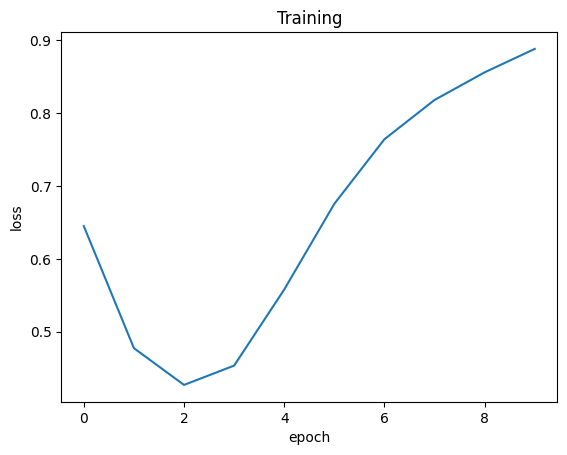

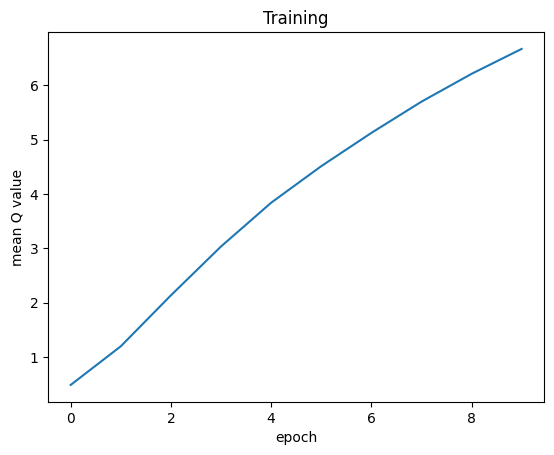

In [14]:
x_length_list = list(range(len(record_b)))
plt.figure()
plt.title('Training')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(x_length_list, record_b)

agent_length_list = list(range(len(record_agent_q)))
plt.figure()
plt.title('Training')
plt.xlabel("epoch")
plt.ylabel("mean Q value")
plt.plot(agent_length_list, [float(q) for q in record_agent_q], label='record_agent_q')

phys_length_list = list(range(len(record_phys_q)))